In [2]:
import pandas as pd

bulk_volume = 800 # A^3

data_dict = [
{'name': 'Vac_O',
  'charge': 2,
  'multiplicity': 1,
  'energy_diff': 7,
  'bulk_volume': bulk_volume},

 {'name': 'Vac_Sr',
  'charge': -2,
  'multiplicity': 1,
  'energy_diff': 8,
  'bulk_volume': bulk_volume},

 {'name': 'Vac_O',
 'charge':0,
 'multiplicity':1,
 'energy_diff': 10.8, 
 'bulk_volume': bulk_volume},

 {'name': 'Vac_Sr',
  'charge': 0,
  'multiplicity': 1,
  'energy_diff': 7.8,
  'bulk_volume': bulk_volume},
  ]

df = pd.DataFrame(data_dict)
df

,name,charge,multiplicity,energy_diff,bulk_volume
0,Vac_O,2,1,7.0,800
1,Vac_Sr,-2,1,8.0,800
2,Vac_O,0,1,10.8,800
3,Vac_Sr,0,1,7.8,800


In [4]:
from defermi import DefectsAnalysis

vbm = 0 # eV
band_gap = 2 # eV
 
da = DefectsAnalysis.from_dataframe(df,band_gap=band_gap,vbm=0)
da

,name,symbol,delta atoms,charge,multiplicity,corrections
0,Vac_O,$V_{O}$,{'O': -1},0,1,{}
1,Vac_O,$V_{O}$,{'O': -1},2,1,{}
2,Vac_Sr,$V_{Sr}$,{'Sr': -1},-2,1,{}
3,Vac_Sr,$V_{Sr}$,{'Sr': -1},0,1,{}


Pulling chemical potentials from Materials Project database...
Chemical potentials:
                 Sr          O
O-poor   -1.689493 -11.102143
O-middle -4.535489  -8.256147
O-rich   -7.381485  -5.410151


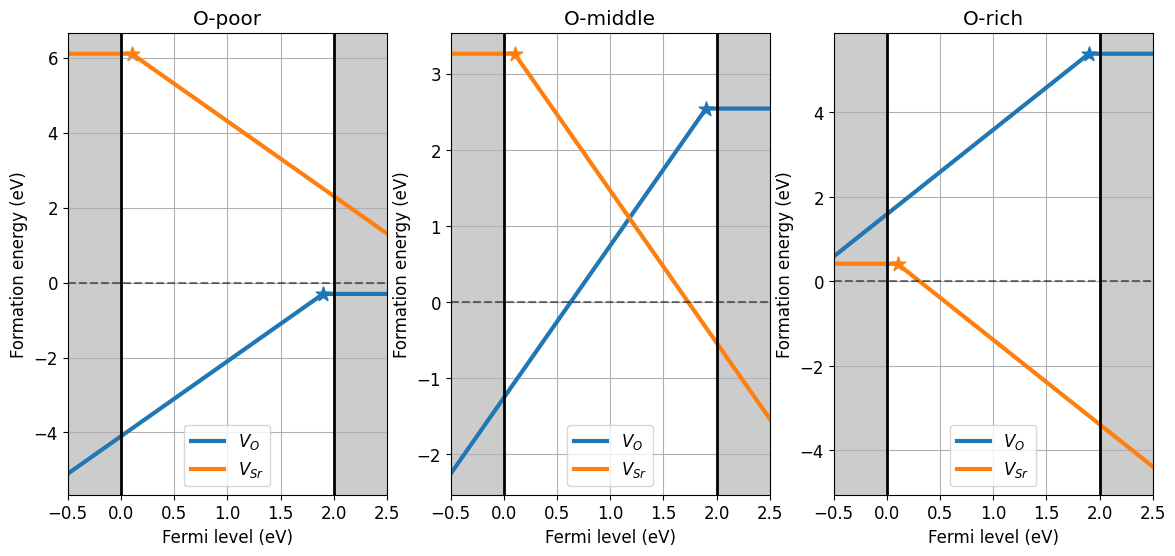

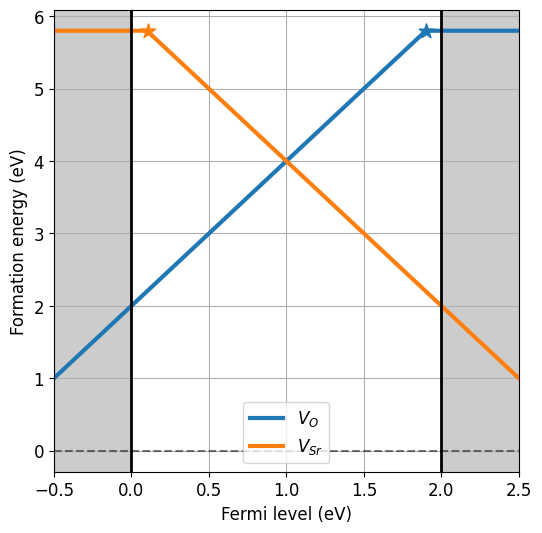

In [9]:
plt = da.plot_formation_energies('SrO',figsize=(14,6));
plt.show()

chempots = {'O': -5, 'Sr': -2}
plt = da.plot_formation_energies(chempots);

In [12]:
da.chempots

,Sr,O
O-poor,-1.689493,-11.102143
O-middle,-4.535489,-8.256147
O-rich,-7.381485,-5.410151


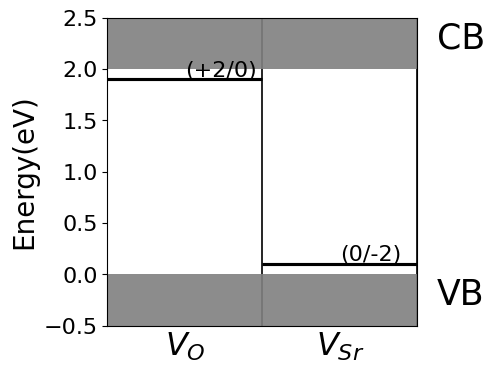

In [26]:
da.plot_ctl(figsize=(4,4));

Pulling precursors energies from Materials Project database


Retrieving ThermoDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ThermoDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

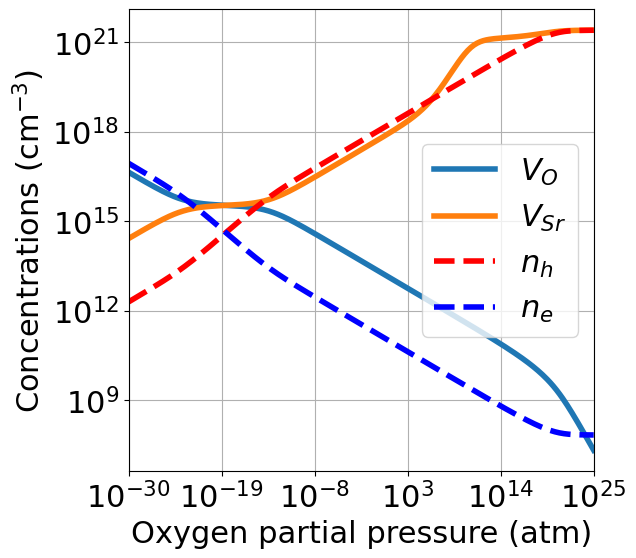

In [6]:
bulk_dos = {'m_eff_e': 0.5, 'm_eff_h': 0.4} # effective masses

#precursors = {'SrO':-10} # energy per formula unit in eV of target material or synthesis precursors
#oxygen_ref = -4.95 # eV - O reference chemical potential at 0 K and standard pressure
precursors = 'SrO'
oxygen_ref = None
npoints = 300
xtol = 1e-30
da.plot_brouwer_diagram(
                    bulk_dos=bulk_dos,
                    temperature=1000,
                    precursors=precursors,
                    oxygen_ref=oxygen_ref,
                    figsize=(6,6),
                    pressure_range=(1e-30,1e25),
                    npoints=npoints,
                    xtol=xtol);

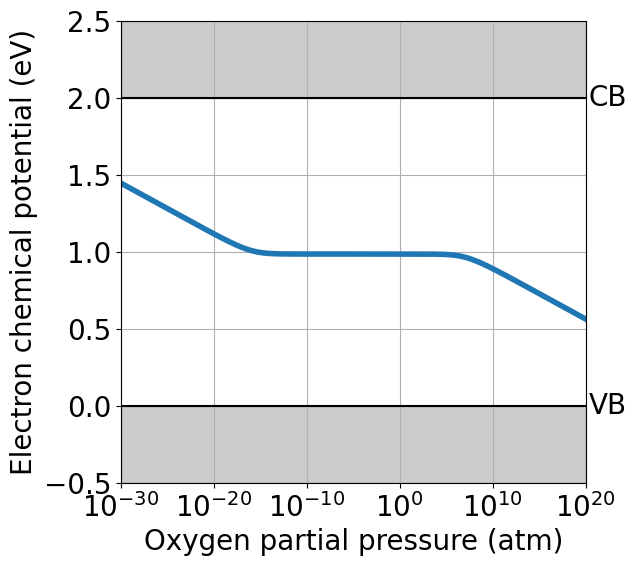

In [28]:
from defermi.plotter import plot_pO2_vs_fermi_level

data = da.thermodata
plot_pO2_vs_fermi_level(
                    partial_pressures=data.partial_pressures,
                    fermi_levels=data.fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));


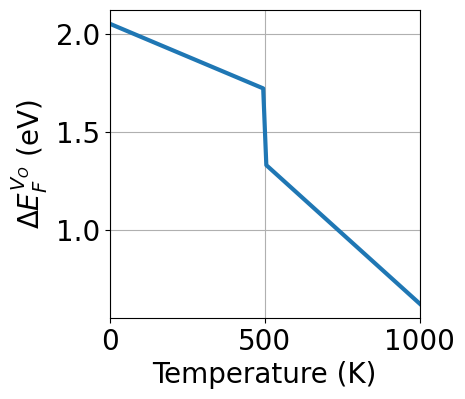

In [29]:
### CUSTOM FUNCTIONS

# T-dependent formation energy
def custom_eform(
                entry,
                vbm=None,
                chemical_potentials=None,
                fermi_level=0,
                temperature=0,
                **kwargs):
        
        formation_energy = entry.energy_diff + entry.charge*(vbm+fermi_level) 
        if chemical_potentials:
            chempot_correction = -1 * sum([entry.delta_atoms[el]*chemical_potentials[el] for el in entry.delta_atoms])
        else:
            chempot_correction = 0
            
        formation_energy = formation_energy + chempot_correction
        if temperature < 500:
            temperature_correction = - 1/1500 *temperature
        else:
            temperature_correction = - 1/700 *temperature
        return formation_energy + temperature_correction       




import numpy as np

X = np.linspace(0,1000,100)
entry = da.select_entries(name='Vac_O',charge=2)[0]
Y = [custom_eform(entry=entry,vbm=0,chemical_potentials=chempots,fermi_level=0,temperature=x) for x in X]
plt.figure(figsize=(4,4))
plt.plot(X,Y,lw=3)
plt.xlabel('Temperature (K)')
plt.ylabel('$\Delta E_F^{V_O}$ (eV)')
plt.xlim(0,1000);
plt.grid();

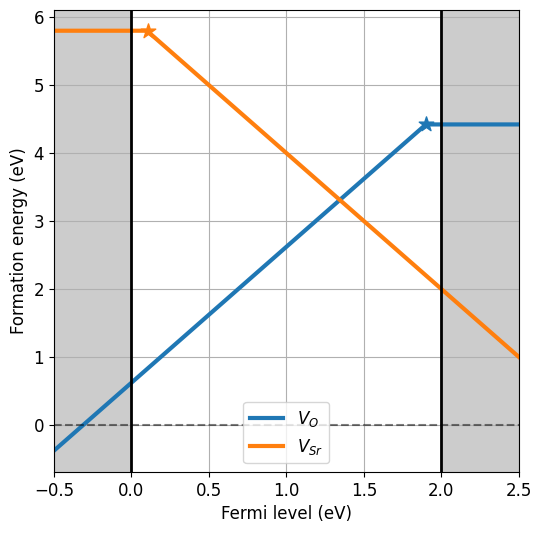

In [30]:
da.set_formation_energy_functions(function=custom_eform,name='Vac_O')
da.plot_formation_energies(chempots,temperature=1000);

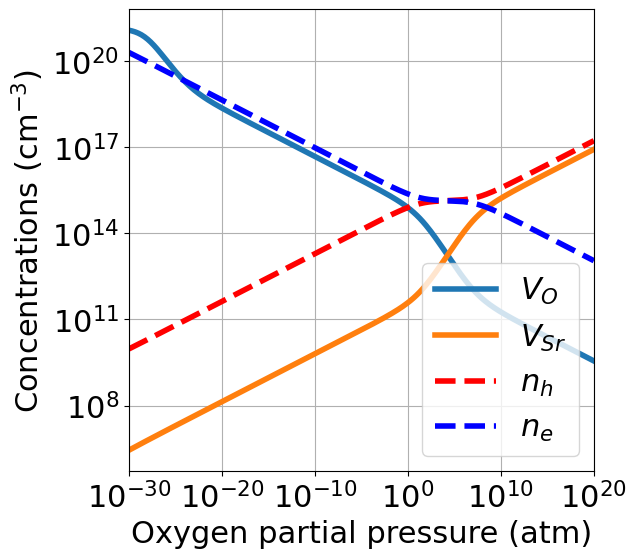

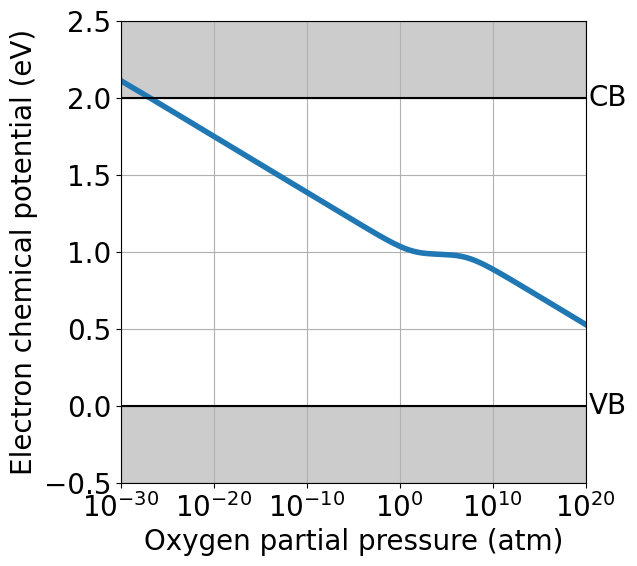

In [31]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1100,
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20),
                        npoints=npoints,
                        xtol=xtol);
plt.show()

data = da.thermodata
plot_pO2_vs_fermi_level(
                    partial_pressures=data.partial_pressures,
                    fermi_levels=data.fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));

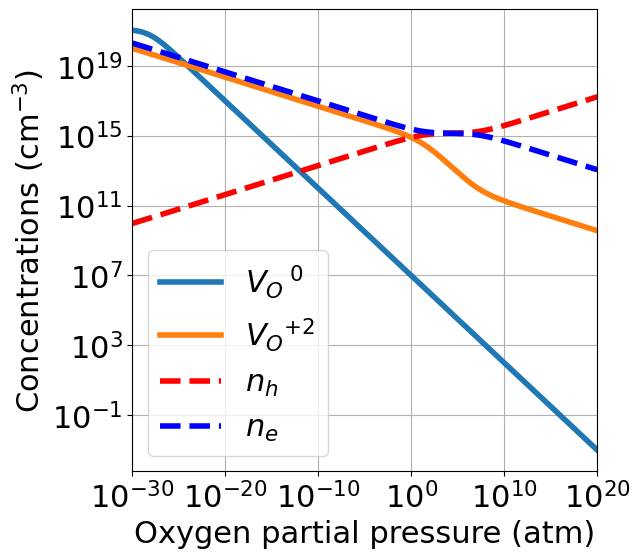

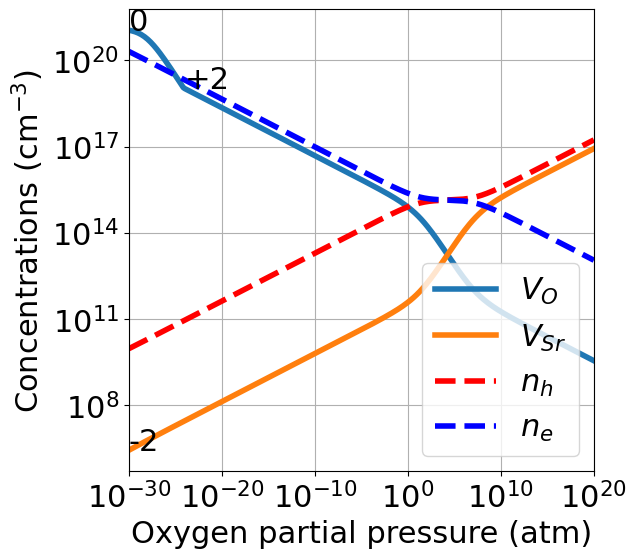

In [32]:
from defermi.plotter import plot_pO2_vs_concentrations

xlim= (1e-30,1e20)

plt = plot_pO2_vs_concentrations(
                    thermodata=data,
                    output='all',
                    xlim=xlim,
                    name='Vac_O',
                    figsize=(6,6))
plt.show()

plt = plot_pO2_vs_concentrations(
                    thermodata=data,
                    output='stable',
                    xlim=xlim,
                    figsize=(6,6))

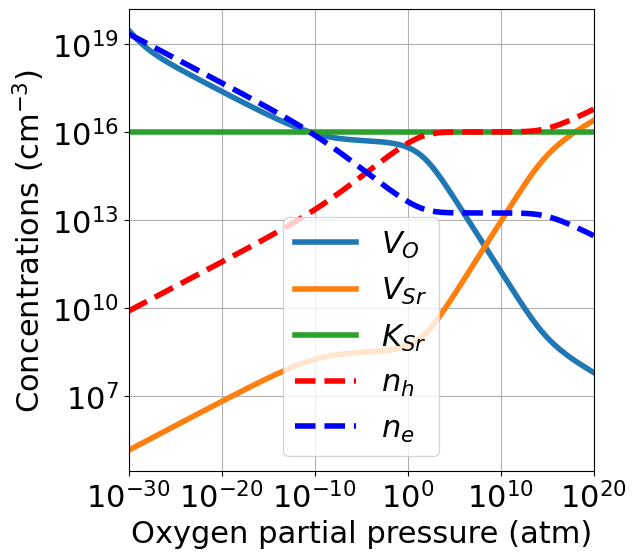

In [33]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        external_defects = [{'name':'Sub_K_on_Sr','charge':-1, 'conc':1e16}],
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20),
                        npoints=npoints,
                        xtol=xtol);

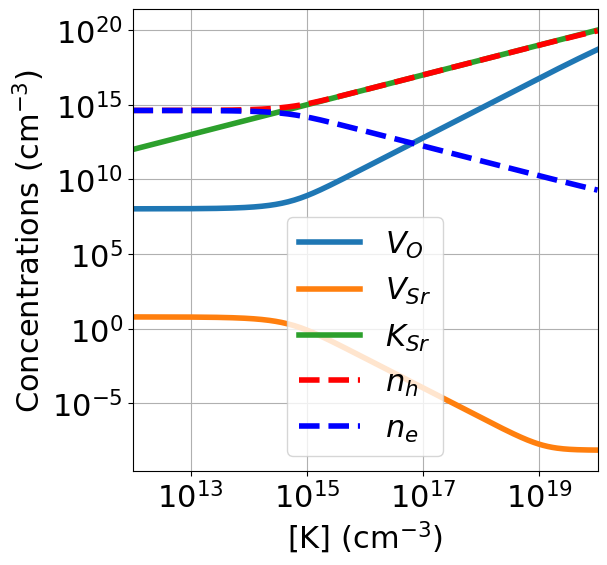

In [34]:
plt = da.plot_doping_diagram(
                        variable_defect_specie={'name':'Sub_K_on_Sr','charge':-1},
                        concentration_range=(1e12,1e20),
                        chemical_potentials=chempots,
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        figsize=(6,6),
                        npoints=npoints,
                        xtol=xtol);

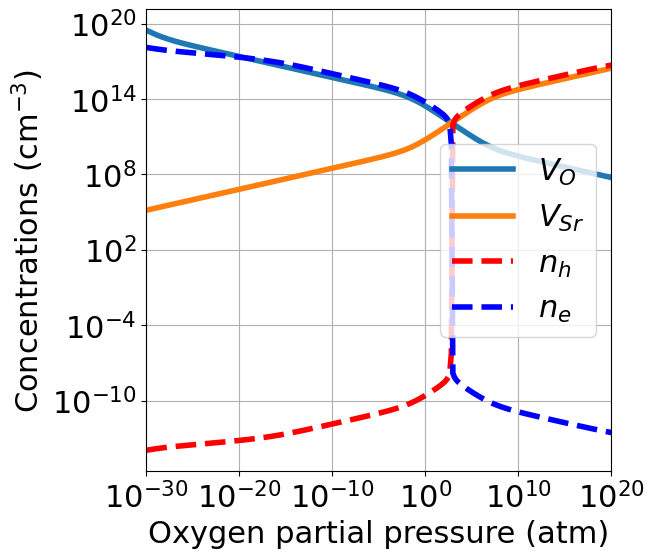

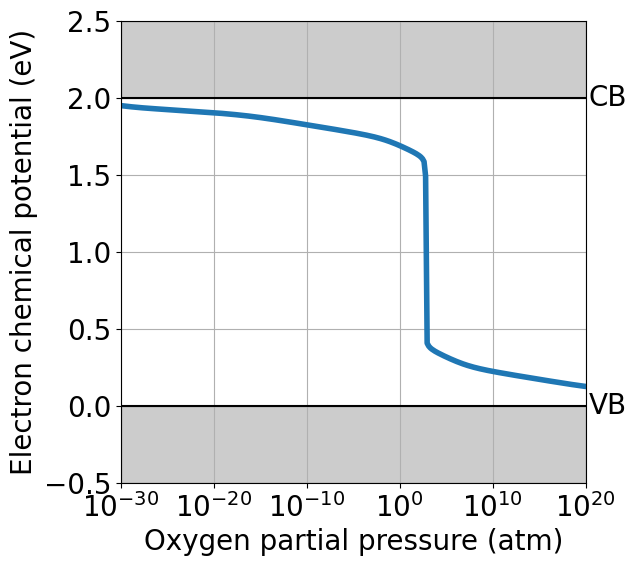

In [35]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        quench_temperature=300,
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20),
                        npoints=npoints,
                        xtol=xtol);
plt.show()

data = da.thermodata
plot_pO2_vs_fermi_level(
                    partial_pressures=data.partial_pressures,
                    fermi_levels=data.fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));

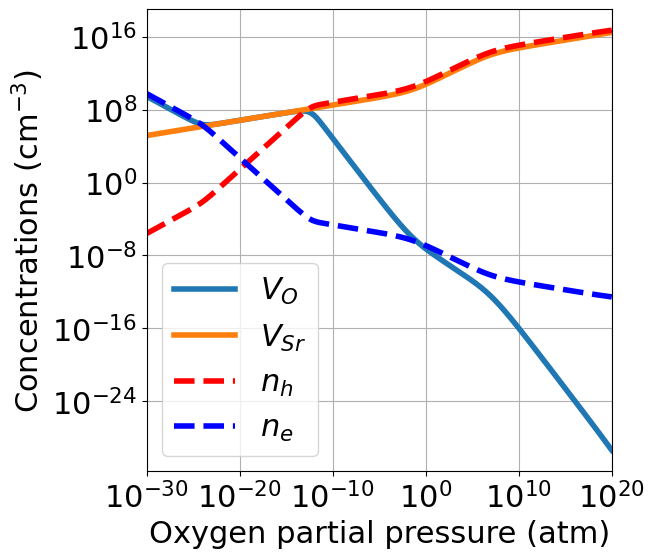

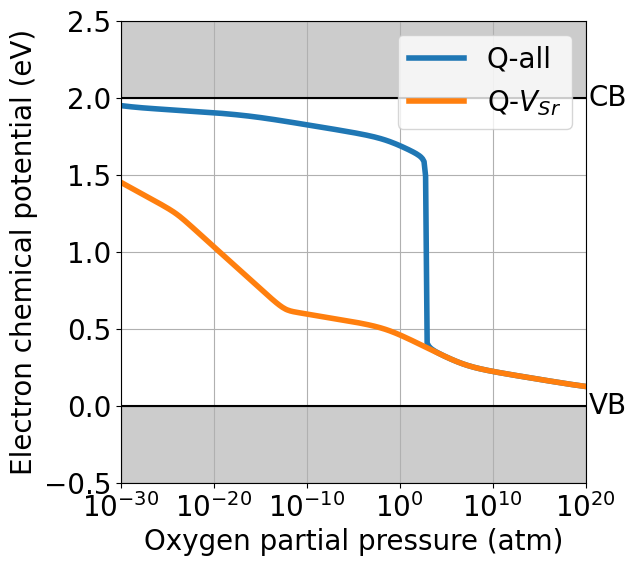

In [36]:
plt = da.plot_brouwer_diagram(
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        quench_temperature=300,
                        quenched_species=['Vac_Sr'],
                        precursors=precursors,
                        oxygen_ref=-4.95,
                        figsize=(6,6),
                        pressure_range=(1e-30,1e20),
                        npoints=npoints,
                        xtol=xtol);
plt.show()

quenched_data = da.thermodata
fermi_levels = {
            'Q-all':data.fermi_levels,
            'Q-$V_{Sr}$':quenched_data.fermi_levels
            }
plot_pO2_vs_fermi_level(
                    partial_pressures=data.partial_pressures,
                    fermi_levels=fermi_levels,
                    band_gap = da.band_gap,
                    figsize=(6,6),
                    xlim=(1e-30,1e20));

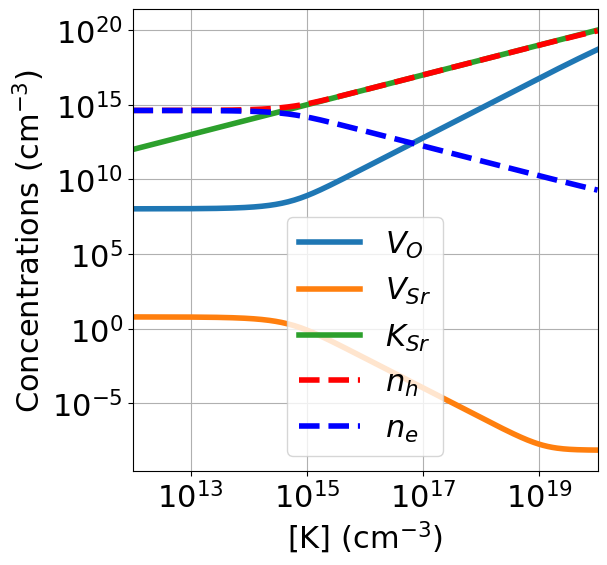

In [37]:
plt = da.plot_doping_diagram(
                        variable_defect_specie={'name':'Sub_K_on_Sr','charge':-1},
                        concentration_range=(1e12,1e20),
                        chemical_potentials=chempots,
                        bulk_dos=bulk_dos,
                        temperature=1000,
                        quench_temperature=300,
                        figsize=(6,6),
                        npoints=npoints,
                        xtol=xtol)

In [38]:
# T-dependence in volume in defect concentrations
def custom_dconc(
                entry,
                vbm=0,
                chemical_potentials=None,
                temperature=0,
                fermi_level=0,
                per_unit_volume=True,
                eform_kwargs={},
                **kwargs):
        
        from pynter.defects.entries import fermi_dirac
        if per_unit_volume:
            temperature_correction_to_volume = 1/500*temperature
            n = entry.defect.site_concentration_in_cm3 
            n = n*(1 + temperature_correction_to_volume)
        else:
             n = entry.multiplicity

        eform = entry.formation_energy(
                                vbm=vbm,
                                chemical_potentials=chemical_potentials,
                                fermi_level=fermi_level,
                                temperature=temperature,
                                **eform_kwargs)
        
        return  n * fermi_dirac(eform,temperature)

In [39]:
da.to_dataframe()

,name,charge,multiplicity,energy_diff,bulk_volume
0,Vac_O,0,1,10.8,800
1,Vac_O,2,1,7.0,800
2,Vac_Sr,-2,1,8.0,800
3,Vac_Sr,0,1,7.8,800
